
https://github.com/krocki/dnc/blob/master/rnn-numpy.py    
https://blog.csdn.net/tudaodiaozhale/article/details/80464060
    
    
http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/     
https://github.com/dennybritz/rnn-tutorial-rnnlm/blob/master/RNNLM.ipynb
    



使用numpy等基本库实现RNN

# 公式
## Notation
输入序列：$x$   
输出序列：$y$   
输入，输出序列中的某个点: $ x^{<t>}, y^{<t>} $  
输入，输出序列的长度: $ T_x^{(i)}, T_y^{(i)} $， 其中i表示第i个样本


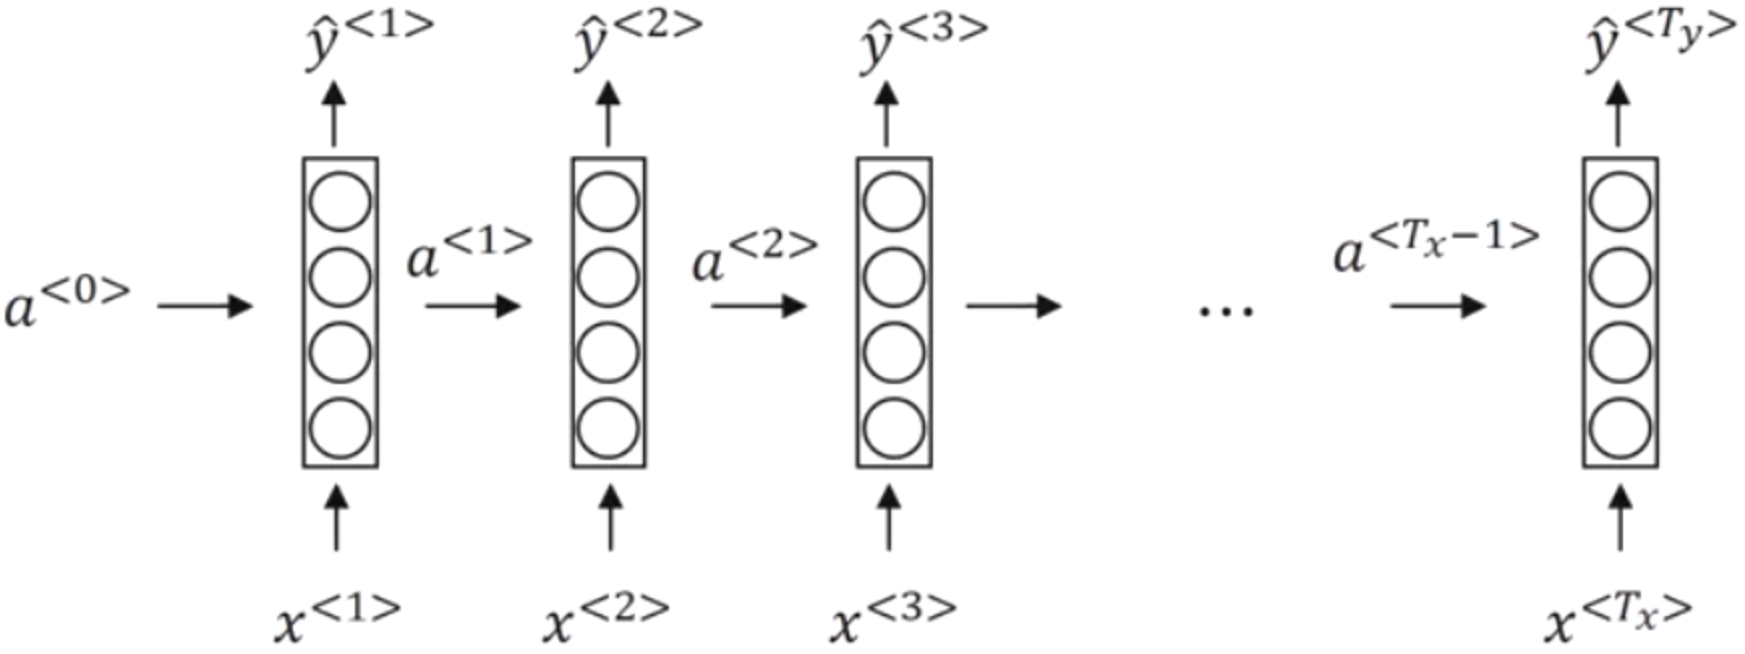



## forward
$$
\begin{align}
a^{<t>} =& tanh( w_{aa}a^{<t-1>} + w_{ax}x^{<t>} + b_a )  \\
\\
\hat y^{<t>} =& softmax(w_{ya}^{<t>} a^{<t>} + b_y) \\
\end{align}
$$


## loss
$$
\begin{align}
E^{<t>} = & - \sum_i y_i^{<t>} ln \hat y_i^{<t>} \\
E(y, \hat y) =& - \sum_t E^{<t>} 
\end{align}
$$

## backpropagation

### 对$w_{ya}, b_y$求导

为了方便下面的推导，细化一下上面的forward公式。同时为了简化公式暂时省略$^{<t>}$
$$
\begin{align}
\\
z =& w_{ya} a + b_y \\
z_i =& \sum_j w_{ya\_ij} a_j + b_{y\_i}  \\
\\
\hat y_i =& \frac{ e^{z_i} }{ \sum_j e^{z_j} }  \\
\end{align}
$$

损失函数：
$$
\begin{align}
E =& -\sum_i y_i ln \hat y_i  \\
  =& -\sum_i y_i ( z_i - ln \sum_j e^{z_j}  ) \\
\end{align}
$$

求导
$$
\begin{align}
\frac{ \partial E }{ \partial w_{ya\_ij} } =& \sum_k \frac{ \partial E }{ \partial z_k }
                        \frac{ \partial z_k }{ \partial w_{ya\_ij}}   \\
                                           =& \frac{ \partial E }{ \partial z_i }
                        \frac{ \partial z_i }{ \partial w_{ya\_ij}}                        
\\
\\
\frac{ \partial E }{ \partial z_i } =& \frac{ \partial ( -\sum_{k \neq i} y_k ( z_k - ln \sum_j e^{z_j}  ) - y_i ( z_i - ln \sum_j e^{z_j}  ) ) }{ \partial z_i }  \\
                                    =& -\sum_{k \neq i} y_k (0 - \frac{e^{z_i}}{ \sum_j e^{z_j} } ) - y_i (1 - \frac{e^{z_i} }{ \sum_j e^{z_j} } )  \\
                                    =& \sum_{k \neq i} y_k \frac{e^{z_i}}{ \sum_j e^{z_j} } - y_i + \frac{e^{z_i}}{ \sum_j e^{z_j}}  \\
                                    =& \sum_k y_k \frac{e^{z_i}}{ \sum_j e^{z_j}} - y_i \\
                                    =& \frac{e^{z_i}}{ \sum_j e^{z_j}} - y_i \\
                                    =& \hat y_i - y_i \\
\\
\\
\frac{ \partial z_i }{ \partial w_{ya\_ij}} =& a_j\\
\end{align}
$$

补上$^{<t>}$，得到
$$
\begin{align}
\frac{ \partial E^{<t>} }{ \partial z_i^{<t>} } =&  \hat y_i^{<t>} - y_i^{<t>} \\
\\
\frac{ \partial E^{<t>} }{ \partial w_{ya\_ij} } =& a_j^{<t>}( \hat y_i^{<t>} - y_i^{<t>} )  \\
\\
\frac{ \partial E^{<t>} }{ \partial b_{y\_i} } =& \hat y_i^{<t>} - y_i^{<t>} 
\end{align}
$$



### 对$w_{aa}, w_{ax}, b_a$求导
细化前向公式
$$
\begin{align}
s_i^{<t>} =& \sum_j w_{aa\_ij}a_j^{<t-1>} + \sum_j w_{ax\_ij}x_j^{<t>} + b_{a\_i} \\
a_i^{<t>} =& tanh( s_i^{<t>} )  \\
\\
z_i^{<t>} =& \sum_j w_{ya\_ij} a_j^{<t>} + b_{y\_i}  \\
\end{align}
$$

对$w_{aa}$求导  
在计算$\frac{\partial E^{<t>}}{\partial w_{aa\_ij}}$时需要考虑所有的$s_i^{<t'>}, 0<t' \le t $
$$
\begin{align}
\frac{ \partial E^{<t>} }{ \partial w_{aa\_ij} } =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s_i^{<t'>}}
                                                              \frac{\partial s_i^{<t'>}}{\partial w_{aa\_ij}}
\end{align}
$$

其中第二项$\frac{\partial s_i^{<t'>}}{\partial w_{aa\_ij}}=a_j^{<t'-1>}$。    
第一项计算比较复杂，下面采用递归的方式计算。当$0<t'<t$时：
$$
\begin{align}
\frac{\partial E^{<t>}}{\partial s_i^{<t'>}} =& \sum_k \frac{\partial E^{<t>}}{\partial s_k^{<t'+1>}}
                                                       \frac{\partial s_k^{<t'+1>}}{\partial s_i^{<t'>}} \\
=& \sum_k \sum_m \frac{\partial E^{<t>}}{\partial s_k^{<t'+1>}}
                 \frac{\partial s_k^{<t'+1>}}{\partial a_m^{<t'>}}
                 \frac{\partial a_m^{<t'>}}{\partial s_i^{<t'>}}\\
=& \sum_k \sum_m \frac{\partial E^{<t>}}{\partial s_k^{<t'+1>}}
                w_{aa_km} \delta_{mi} ( 1-(a_i^{<t'>})^2 ) \\
=& \sum_k \frac{\partial E^{<t>}}{\partial s_k^{<t'+1>}}
                w_{aa_ki}( 1-(a_i^{<t'>})^2 ) \\
=& \sum_k w_{aa\_ik}^T  \frac{\partial E^{<t>}}{\partial s_k^{<t'+1>}} ( 1-(a_i^{<t'>})^2 ) 
\end{align}
$$

递推公式的初始值:
$$
\begin{align}
\frac{\partial E^{<t>}}{ \partial s_i^{<t>}} =& \sum_m \sum_n \frac{ \partial E^{<t>} }{ \partial z_m^{<t>} } 
                                                       \frac{ \partial z_m^{<t>}}{ \partial a_n^{<t>} }
                                                       \frac{ \partial a_n^{<t>}}{ \partial s_i^{<t>} } \\
=& \sum_m \sum_n (\hat y_i^{<t>} - y_i^{<t>}) w_{ya\_mn} \delta_{ni} ( 1 - (a_i^{<t>})^2 )\\ 
=& \sum_m (\hat y_i^{<t>} - y_i^{<t>}) w_{ya\_mi} ( 1 - (a_i^{<t>})^2 )\\ 
=& \sum_m w_{ya\_im}^T(\hat y_i^{<t>} - y_i^{<t>})( 1 - (a_i^{<t>})^2 )\\
\end{align}
$$

在算好$\frac{\partial E^{<t>}}{\partial s_i^{<t>}}$后，就比较容易得到对$w_{ax}, b_a$的导数
$$
\begin{align}
\frac{\partial E^{<t>}}{\partial w_{ax\_ij}} =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s_i^{<t'>}}
                                                              \frac{\partial s_i^{<t'>}}{\partial w_{ax\_ij}} \\
=& \sum_{t'} \frac{\partial E^{<t>}}{\partial s_i^{<t'>}} x_i^{<t'>}     \\                                       
\\
\frac{\partial E^{<t>}}{\partial b_{a\_i}} =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s_i^{<t>}}
                                                        \frac{\partial s_i^{<t>}}{\partial b_{a\_i}} \\
=& \sum_{t'} \frac{\partial E^{<t>}}{\partial s_i^{<t'>}}    \\    
\end{align}
$$

### 矩阵形式   

对$w_{ya}, b_y$的导数
$$
\begin{align}
\frac{ \partial E^{<t>} }{ \partial w_{ya} } =& (\hat y^{<t>} - y^{<t>} ) \otimes a^{<t>}   \\
\\
\frac{ \partial E^{<t>} }{ \partial b_y}  =& \hat y^{<t>} - y^{<t>} 
\end{align}
$$

$\frac{\partial E^{<t>}}{\partial s^{<t>}}$的递推公式：
$$
\begin{align}
\frac{\partial E^{<t>}}{ \partial s^{<t>}} =& w_{ya}^T(\hat y^{<t>} - y^{<t>}) * ( 1 - (a^{<t>})^2 )\\
\\
\frac{\partial E^{<t>}}{\partial s^{<t'>}} =& w_{aa}^T \frac{\partial E^{<t>}}{\partial s^{<t'+1>}} * ( 1-(a^{<t'>})^2 ) 
\end{align}
$$

对$w_{aa}, w_{ax}, b_a$的导数
$$
\begin{align}
\frac{\partial E^{<t>}}{\partial w_{aa}} =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s^{<t'>}} \otimes a^{<t'-1>}     \\                   
\frac{\partial E^{<t>}}{\partial w_{ax}} =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s^{<t'>}} \otimes x^{<t'>}
\\
\frac{\partial E^{<t>}}{\partial b_a} =& \sum_{t'} \frac{\partial E^{<t>}}{\partial s^{<t'>}}
\end{align}
$$

In [ ]:
def softmax(x):
    e_x = np.exp( x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [2]:
class RNN(object):
    def __init__(self, hid_dim, inp_dim, out_dim):
        self.w_ax = np.random.uniform(-np.sqrt(1.0/inp_dim), np.sqrt(1.0/inp_dim), (hid_dim, inp_dim))
        self.w_aa = np.random.uniform(-np.sqrt(1.0/hid_dim), np.sqrt(1.0/hid_dim), (hid_dim, hid_dim))
        self.w_ya = np.random.uniform(-np.sqrt(1.0/hid_dim), np.sqrt(1.0/hid_dim), (out_dim, hid_dim))
        self.b_a = np.zeros( (hid_dim,1), dtype=float )
        self.b_y = np.zeros( (out_dim,1), dtype=float )
        self.inp_dim = inp_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
    def forward(self, x):
        T = len(x)
        a = np.zeros( (T + 1, self.hid_dim), dtype=float )
      
        w_ax = self.w_ax
        w_aa = self.w_aa
        w_ya = self.w_ya
        b_a = self.b_a
        b_y = self.b_y
        y_hat = zeros( (T, self.out_dim), dtype=float )
        for t in range(T):
            a[t] = np.tanh(np.dot(w_aa, a[t-1]) + np.dot(w_ax, x[t]) + b_a)
            z = np.dot(w_ya, a[t]) + b_y
            y_hat[t] = softmax(z)
            
        return [y_hat, a]
            
    def predict(self, x):
        y_hat, _ = self.forward(x)
        return np.argmax(y_hat, axis=1)
    
    def train(x, y, a_prev):
        a = {}
        a[-1] = np.copy(a_prev)
        
            
            